# ParikhSamuolisReclassificationNN
## date last modified: Nov 8, 2024

# Loading Data and Necessary Libraries (add in here as we use more)

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil

In [12]:
## personal directories for entry
## ok basically, because both of our computers won't be set up the exact same way (like for file directories)
## running the command in this cell should get you your file path to paste in the next cell
## all you have to make sure is that you have all the training files and testing files in the ParikhSamuolisReclassificationNN folder
import os
print(os.getcwd())

/Users/riyaparikh_computeracct/Downloads/DS340/ParikhSamuolisReclassificationNN


In [2]:
# prompt for the base directory 
base_dir = input("Enter the base directory path for the dataset: ")

# verify the path
print("Base directory set to:", base_dir)

Enter the base directory path for the dataset: /Users/riyaparikh_computeracct/Downloads/DS340/ParikhSamuolisReclassificationNN
Base directory set to: /Users/riyaparikh_computeracct/Downloads/DS340/ParikhSamuolisReclassificationNN


In [13]:
# set up data_paths to keep track of each category and split:
# dictionary to store paths for each bird category and split (train/validation)
data_paths = {
    'train': {
        'baldeagle': os.path.join(base_dir, 'baldeagletrain'),
        'blackgrouse': os.path.join(base_dir, 'blackgrousetrain'),
        'chickadee': os.path.join(base_dir, 'chickadeetrain'),
        'goldfinch': os.path.join(base_dir, 'goldfinchtrain'),
    },
    'validation': {
        'baldeagle': os.path.join(base_dir, 'baldeagleval'),
        'blackgrouse': os.path.join(base_dir, 'blackgrouseval'),
        'chickadee': os.path.join(base_dir, 'chickadeeval'),
        'goldfinch': os.path.join(base_dir, 'goldfinchval'),
    }
}

# verify each path to make sure everything is correct
for split, categories in data_paths.items():
    for category, path in categories.items():
        print(f"{split} - {category}: {os.path.exists(path)}")

train - baldeagle: True
train - blackgrouse: True
train - chickadee: True
train - goldfinch: True
validation - baldeagle: True
validation - blackgrouse: True
validation - chickadee: True
validation - goldfinch: True


In [4]:
# loading and checking sizes of the images
# found this link for if necessary to resize: https://patrykchrabaszcz.github.io/Imagenet32/
def load_and_check_sizes(data_paths):
    sizes = {}
    for split in ['train', 'validation']:
        sizes[split] = {}
        for category, path in data_paths[split].items():
            sizes[split][category] = []
            for img_name in os.listdir(path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check for valid image extensions
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes[split][category].append(img.size)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    return sizes

image_sizes = load_and_check_sizes(data_paths)
print(image_sizes)  

{'train': {'baldeagle': [(224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (224, 224), (22

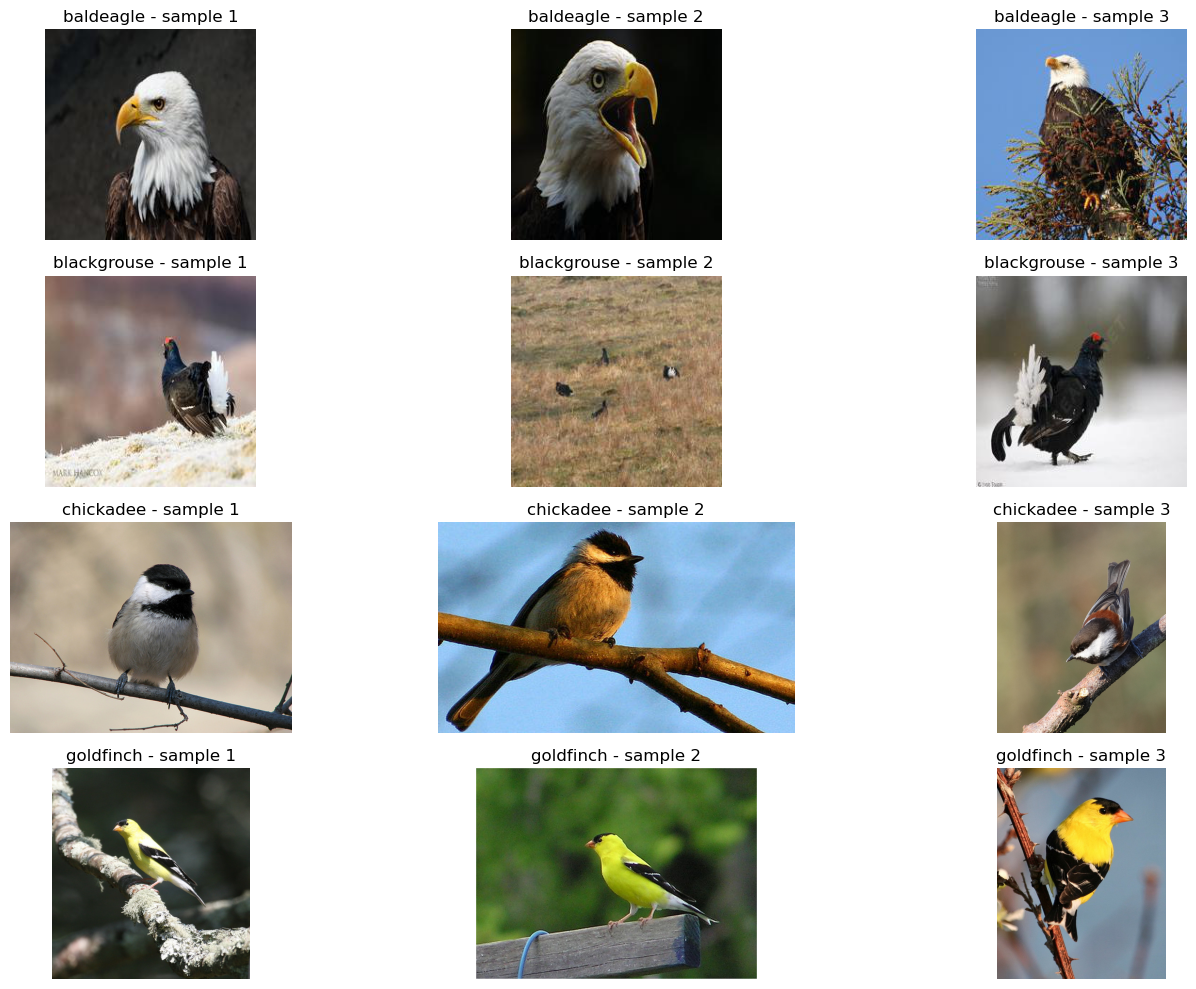

In [5]:
# see if images are displaying properly in each category just as a check
def display_sample_images(data_paths, num_samples=3):
    fig, axs = plt.subplots(4, num_samples, figsize=(15, 10))  # 4 categories, 3 samples each
    
    for i, (category, path) in enumerate(data_paths['train'].items()):
        img_names = os.listdir(path)[:num_samples]
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"{category} - sample {j+1}")
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(data_paths)

In [9]:
def resize_images_vgg(data_paths, target_size=(224, 224), save_dir="resized_images"):
    # create the new directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            # create category subfolders in the save directory
            category_dir = os.path.join(save_dir, split, category)
            if not os.path.exists(category_dir):
                os.makedirs(category_dir)

            for img_name in os.listdir(path):
                # skip non-image files like .DS_Store - this lowkey might not be a problem for you tomas, but it was being weird on my mac so i found this fix online
                # having it shouldn't cause you any issues though either because it just won't throw the exception
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            img_resized = img.resize(target_size)
                            # Save the resized image to the new directory
                            new_img_path = os.path.join(category_dir, img_name)
                            img_resized.save(new_img_path)  
                    except Exception as e:
                        print(f"Error loading or resizing image {img_path}: {e}")

# resize images and save them in a new folder
resize_images_vgg(data_paths, target_size=(224, 224))

In [10]:
def load_and_prepare_data(data_paths, target_size=(224, 224)):
    data = {'train': {}, 'validation': {}}
    
    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            images = []
            labels = []
            label = list(data_paths[split].keys()).index(category)  # numeric label for each category
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                # skip non-image files (mac only issue?)
                if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                with Image.open(img_path) as img:
                    img_resized = img.resize(target_size)
                    img_array = np.array(img_resized) / 255.0  # normalize pixel values
                    if img_array.ndim == 2:  # if the image is grayscale, add a third channel
                        img_array = np.expand_dims(img_array, axis=-1)
                        img_array = np.repeat(img_array, 3, axis=-1)  # repeat the grayscale to rgb
                    images.append(img_array)
                    labels.append(label)
            # store images and labels for each category as 3D arrays
            data[split][category] = (np.array(images), np.array(labels))
    
    return data

# prepare the data
prepared_data = load_and_prepare_data(data_paths, target_size=(224, 224))

# verifying shape of loaded data arrays
for split in prepared_data:
    for category in prepared_data[split]:
        images, labels = prepared_data[split][category]
        print(f"{split} - {category}: images shape = {images.shape}, labels shape = {labels.shape}")

train - baldeagle: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - blackgrouse: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - chickadee: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - goldfinch: images shape = (1300, 224, 224, 3), labels shape = (1300,)
validation - baldeagle: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - blackgrouse: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - chickadee: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - goldfinch: images shape = (50, 224, 224, 3), labels shape = (50,)


## Starting Relabeling of Baldeagle to Blackgrouse
### Only picking one other category to reclassify to  simplify the setup and analysis, as weâ€™d only need to track whether the model can reclassify them from one incorrect category

In [15]:
# currently doing 20% reclassification
def relabel_images(category_to_mislabel, target_category, data_paths, percentage=0.2):
    original_folder = data_paths['train'][category_to_mislabel]
    target_folder = data_paths['train'][target_category]
    
    # Get a list of image filenames in the original category
    images = [img for img in os.listdir(original_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Determine the number of images to move based on the specified percentage
    num_to_move = int(len(images) * percentage)
    images_to_relabel = random.sample(images, num_to_move)

    # Move each selected image to the target category folder
    for img_name in images_to_relabel:
        img_path = os.path.join(original_folder, img_name)
        new_path = os.path.join(target_folder, img_name)
        shutil.move(img_path, new_path)
        print(f"Moved {img_name} from {category_to_mislabel} to {target_category}")

# Example usage:
relabel_images('baldeagle', 'blackgrouse', data_paths, percentage=0.2)

Moved n01614925_907.JPEG from baldeagle to blackgrouse
Moved n01614925_9920.JPEG from baldeagle to blackgrouse
Moved n01614925_3617.JPEG from baldeagle to blackgrouse
Moved n01614925_191.JPEG from baldeagle to blackgrouse
Moved n01614925_43817.JPEG from baldeagle to blackgrouse
Moved n01614925_2138.JPEG from baldeagle to blackgrouse
Moved n01614925_8529.JPEG from baldeagle to blackgrouse
Moved n01614925_48741.JPEG from baldeagle to blackgrouse
Moved n01614925_6742.JPEG from baldeagle to blackgrouse
Moved n01614925_5842.JPEG from baldeagle to blackgrouse
Moved n01614925_6204.JPEG from baldeagle to blackgrouse
Moved n01614925_3126.JPEG from baldeagle to blackgrouse
Moved n01614925_17877.JPEG from baldeagle to blackgrouse
Moved n01614925_44959.JPEG from baldeagle to blackgrouse
Moved n01614925_8979.JPEG from baldeagle to blackgrouse
Moved n01614925_29818.JPEG from baldeagle to blackgrouse
Moved n01614925_4506.JPEG from baldeagle to blackgrouse
Moved n01614925_5934.JPEG from baldeagle to b

In [16]:
# want to know how many images are in each category after "misclassifying"
def count_images(data_paths):
    category_counts = {'train': {}, 'validation': {}}

    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            # Count only image files (skip any non-image files, like .DS_Store)
            image_files = [img_name for img_name in os.listdir(path) if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))]
            category_counts[split][category] = len(image_files)

    return category_counts

image_counts = count_images(data_paths)
for split, categories in image_counts.items():
    print(f"\n{split.capitalize()} Split:")
    for category, count in categories.items():
        print(f"  {category}: {count} images")


Train Split:
  baldeagle: 1040 images
  blackgrouse: 1560 images
  chickadee: 1300 images
  goldfinch: 1300 images

Validation Split:
  baldeagle: 50 images
  blackgrouse: 50 images
  chickadee: 50 images
  goldfinch: 50 images
